# Exploratory Data Analysis

### Code Authors:
Eimaan Saqib

Harris Ahmad

In [49]:
import pandas as pd
import numpy as np
from itertools import chain
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.interpolate import interp1d

In [2]:
# making the title column as index since it is unique for every row
df = pd.read_csv('dataset.csv')
# resetting the index so it starts from 1
df.index = np.arange(1, len(df) + 1)
# dropping unnamed columns that have nan as their only value
df.drop(['Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'], axis=1, inplace=True)
df.rename(columns={'strong_janguage':'strong_language'}, inplace=True)

## Data Cleaning & Preprocessing

In [3]:
# dropping all rows with nan values
df = df.dropna(axis=0)

In [4]:
def col_unique_count(col: pd.Series, ordered=False) -> dict:
    temp = col.to_list()
    temp = [list(t.split(',')) for t in temp]
    temp = list(chain.from_iterable(temp))
    temp = [t.strip() for t in temp]

    count = {}
    for t in temp:
        if t in count:
            count[t] += 1
        else:
            count[t] = 1
    # if sorted flag is true, sort dict by values (descending)
    if ordered:
        count = dict(sorted(count.items(), key=lambda item: item[1], reverse=True))
    return count

#### Classifying games according to genres.
Every unique genre would be on the x-axis and the count of each would be on the y-axis.
Notice how every genre is a non-atomic value meaning that it could be divided into multiple genres (simplified).

* some genres are vague to a great degree
* since there are a lot of redundant values, we can select top 10 most popular genres

In [5]:
# this function returns the unique count of genres in 
genre_count = col_unique_count(df['genres'], True)

In [ ]:
genre_count

In [ ]:
plt.figure(figsize=(30,70))
y = list(genre_count.keys())
x = list(genre_count.values())
sns.barplot(x=x, y=y, orient='h')
plt.title('Number of video games containing each genre')
plt.show()

How many games do developers on average release and what is their mean rating? Do developers with more games have a higher mean rating?

In [6]:
developer_count = col_unique_count(df['developers'], True)
# pprint(developer_count)
developer_count

In [7]:
user_ratings = {}
for developer in developer_count.keys():
    avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])
    user_ratings[developer] = avg
user_ratings

C:\Users\User\AppData\Local\Temp\ipykernel_9656\4150574831.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])


In [8]:
meta_ratings = {}
for developer in developer_count.keys():
    avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])
    meta_ratings[developer] = avg
meta_ratings

C:\Users\User\AppData\Local\Temp\ipykernel_9656\245426873.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])


In [ ]:
x = list(developer_count.values())
y1 = list(user_ratings.values())
sns.regplot(x, y1, ci=None)
plt.xlabel("Number of games developed by a developer")
plt.ylabel("Average user score on the games")

In [ ]:
y2 = list(meta_ratings.values())
sns.regplot(x, y2, ci=None)
plt.xlabel("Number of games developed by a developer")
plt.ylabel("Average metacritic score on the games")

How do the popular genres vary over the year?

In [9]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce', format='%Y/%m/%d')

In [10]:
months = df['release_date'].dt.month
months

1       3.0
2       5.0
3       4.0
4       3.0
5       3.0
       ... 
1635    1.0
1638    3.0
1639    8.0
1641    8.0
1642    8.0
Name: release_date, Length: 1400, dtype: float64

In [11]:
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

In [12]:
popular_genres = {}
for month in range(1,13):
    month_df = df[df['release_date'].dt.month == month]
    most_popular = []
    popular_rating = -1*np.inf
    for genre in genre_count:
        avg = np.mean(month_df[month_df['genres'].str.contains(genre)]['metascritic_score'])
        if avg > popular_rating:
            most_popular = [genre]
            popular_rating = avg
        elif avg==popular_rating:
            most_popular.append(genre)
    popular_genres[month_map[month]] = {'genres':most_popular, 'average metacritic score':popular_rating}
popular_genres

In [13]:
user_popular_genres = {}
for month in range(1,13):
    month_df = df[df['release_date'].dt.month == month]
    most_popular = []
    popular_rating = -1*np.inf
    for genre in genre_count:
        avg = np.mean(month_df[month_df['genres'].str.contains(genre)]['users_score'])
        if avg > popular_rating:
            most_popular = [genre]
            popular_rating = avg
        elif avg==popular_rating:
            most_popular.append(genre)
    user_popular_genres[month_map[month]] = {'genres':most_popular, 'average user score':popular_rating}
user_popular_genres

How does this trend in genres vary over the years?

In [14]:
all_years = np.sort(df['release_date'].dt.year.dropna().unique().astype(int))

In [15]:
yearly_popular_genres = {}
for year in all_years:
    year_df = df[df['release_date'].dt.year == year]
    most_popular = []
    popular_rating = -1*np.inf
    for genre in genre_count:
        avg = np.mean(year_df[year_df['genres'].str.contains(genre)]['metascritic_score'])
        if avg > popular_rating:
            most_popular = [genre]
            popular_rating = avg
        elif avg==popular_rating:
            most_popular.append(genre)
    yearly_popular_genres[year] = {'genres':most_popular, 'average metacritic score':popular_rating}
pprint(yearly_popular_genres)

Do metacritic scores and user scores align with each other?

In [ ]:
sns.regplot(data=df, x='metascritic_score', y='users_score')

In [ ]:
df[df['metascritic_score']==0]

In [ ]:
df[df['users_score']==0]

Which developers consistently get the highest ratings? Is there a trend in popular genres among these high rated developers?

In [16]:
all_developers = list(pd.Series(developer_count.keys()).unique())

In [17]:
developer_ratings = {}
for developer in all_developers:
    avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])
    developer_ratings[developer] = avg
developer_ratings = dict(sorted(developer_ratings.items(), key=lambda item: item[1], reverse=True))

C:\Users\User\AppData\Local\Temp\ipykernel_9656\1002868910.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  avg = np.mean(df[df['developers'].str.contains(developer)]['metascritic_score'])


In [ ]:
developer_ratings

In [18]:
developer_userratings = {}
for developer in all_developers:
    avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])
    developer_userratings[developer] = avg
developer_userratings = dict(sorted(developer_userratings.items(), key=lambda item: item[1], reverse=True))

C:\Users\User\AppData\Local\Temp\ipykernel_9656\2562103469.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  avg = np.mean(df[df['developers'].str.contains(developer)]['users_score'])


In [ ]:
developer_userratings

In [19]:
meta_top10 = dict(list(developer_ratings.items())[:10])
meta_top10

In [20]:
user_top10 = dict(list(developer_userratings.items())[:10])
user_top10

Do the top 10 user rated developers develop more games with certain genres? How does this trend appear in top 10 metacritic rated developers?

In [21]:
fav_genres = {}
for developer in list(user_top10.keys()):
    dev_df = df[df['developers'].str.contains(developer)]
    genre_counts = col_unique_count(dev_df['genres'], True)
    top_3 = list(genre_counts.keys())[:3]
    fav_genres[developer] = top_3
pprint(fav_genres)

In [22]:
fav_genres_meta = {}
for developer in list(meta_top10.keys()):
    dev_df = df[df['developers'].str.contains(developer)]
    genre_counts = col_unique_count(dev_df['genres'], True)
    top_3 = list(genre_counts.keys())[:3]
    fav_genres_meta[developer] = top_3
pprint(fav_genres_meta)

Correlation between different video game features and the ratings produced

In [23]:
df_ratings = df.drop(['title','console','esrb_rating','index','release_date','publishers','developers',
                      'rating','genres'], axis=1)

In [ ]:
df_ratings.head(3)

In [ ]:
plt.figure(figsize=(16, 10))
corr_heatmap = sns.heatmap(df_ratings.corr(), annot=False)
plt.show()

What features have a negative correlation with ratings?

In [ ]:
df_ratings.corr()[(df_ratings.corr()['metascritic_score']<0) & (df_ratings.corr()['users_score']<0)][['metascritic_score','users_score']]

Categorizing the total number of movies according to ESRB Rating

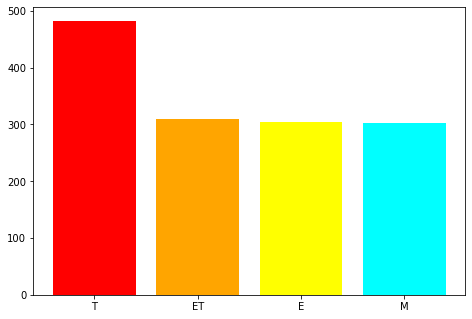

In [24]:
esrb_genres = df[['esrb_rating', 'genres']]
esrb_value_counts = esrb_genres['esrb_rating'].value_counts().to_dict()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_value_counts.values()
labels_index = esrb_value_counts.keys()
ax.bar(labels_index, data_points, color=['red', 'orange', 'yellow', 'aqua'])
plt.show()

In [25]:
df.columns

Index(['title', 'console', 'alcohol_reference', 'animated_blood', 'blood',
       'blood_and_gore', 'cartoon_violence', 'crude_humor', 'drug_reference',
       'fantasy_violence', 'intense_violence', 'language', 'lyrics',
       'mature_humor', 'mild_blood', 'mild_cartoon_violence',
       'mild_fantasy_violence', 'mild_language', 'mild_lyrics',
       'mild_suggestive_themes', 'mild_violence', 'no_descriptors', 'nudity',
       'partial_nudity', 'sexual_content', 'sexual_themes',
       'simulated_gambling', 'strong_language', 'strong_sexual_content',
       'suggestive_themes', 'use_of_alcohol', 'use_of_drugs_and_alcohol',
       'violence', 'esrb_rating', 'index', 'release_date', 'publishers',
       'developers', 'rating', 'metascritic_score', 'users_score', 'genres'],
      dtype='object')

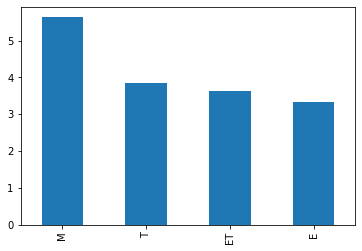

In [26]:
esrb = list(df['esrb_rating'].unique())
esrb_userscore = {}
for rat in esrb:
    avg = np.mean(df[df['esrb_rating'].str.contains(rat)]['users_score'])
    esrb_userscore[rat] = avg
esrb_userscore = dict(sorted(esrb_userscore.items(), key=lambda item: item[1], reverse=True))
esrb_userscore = pd.Series(esrb_userscore).plot(kind='bar')

<AxesSubplot:>

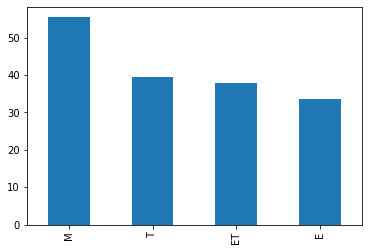

In [27]:
esrb = list(df['esrb_rating'].unique())
esrb_metacritic = {}
for rat in esrb:
    avg = np.mean(df[df['esrb_rating'].str.contains(rat)]['metascritic_score'])
    esrb_metacritic[rat]=avg
esrb_metacritic = dict(sorted(esrb_metacritic.items(), key=lambda item: item[1], reverse=True))
pd.Series(esrb_metacritic).plot(kind='bar')

In [28]:
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
esrb_trend_months = {}
for month in range(1,13):
    month_df = df[df['release_date'].dt.month == month]['esrb_rating'].value_counts().to_dict()
    esrb_trend_months[month_map[month]] = month_df
'''
We can represent this information for every esrb rating
individually over the months
'''
esrb_T = {}
esrb_ET = {}
esrb_M = {}
esrb_E = {}
for month in esrb_trend_months.items():
    esrb_T[month[0]] = month[1]['T']
    esrb_ET[month[0]] = month[1]['ET']
    esrb_M[month[0]] = month[1]['M']
    esrb_E[month[0]] = month[1]['E']

Trend of E-rated games over the months

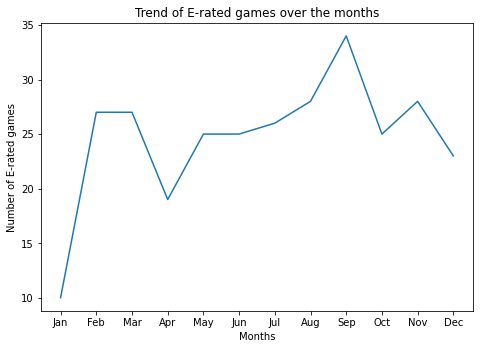

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_E.values()
labels_index = esrb_E.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of E-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of E-rated games')
plt.show()

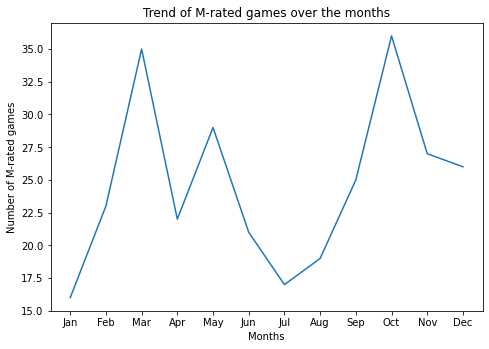

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_M.values()
labels_index = esrb_M.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of M-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of M-rated games')
plt.show()

One interesting observation that could be drawn using the above plot is how the number of M-rated games peaked in October. This is when halloween takes place, and the content produced during this time around is also M-rated. Hence, there is an evident trend observed here.

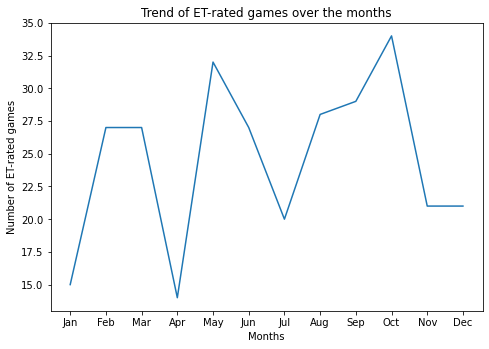

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_ET.values()
labels_index = esrb_ET.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of ET-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of ET-rated games')
plt.show()

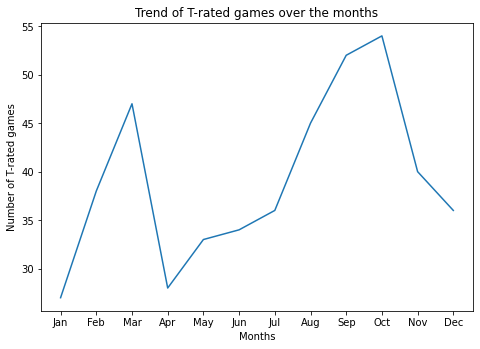

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data_points = esrb_T.values()
labels_index = esrb_T.keys()
ax.plot(labels_index, data_points)
plt.title('Trend of T-rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of T-rated games')
plt.show()

Comparing the plots

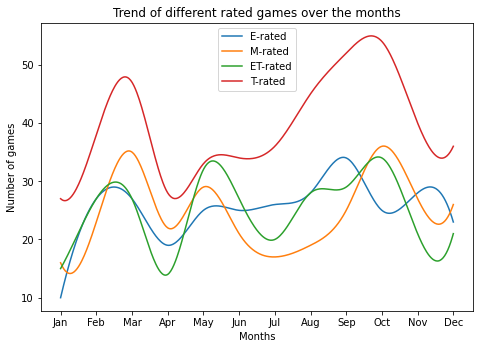

In [62]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels_index = np.array(range(1,13))

X_ = np.linspace(np.min(labels_index), np.max(labels_index), 500)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_E.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_M.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_ET.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

cubic_interpolation_model = interp1d(labels_index, np.array(list(esrb_T.values())), kind = "cubic")
Y_= cubic_interpolation_model(X_)
ax.plot(X_, Y_)

plt.xticks(np.arange(1, 13, 1.0))
ax.set_xticklabels(list(month_map.values()))
plt.title('Trend of different rated games over the months')
plt.xlabel('Months')
plt.ylabel('Number of games')
plt.legend(['E-rated','M-rated','ET-rated','T-rated'])
plt.show()

**Observation:** The production of all games peaked around Feb-Mar and Sep-Oct before going on a decline. M-rated and ET-rated games saw a surge in May before a sudden drop, while the release of E-rated and T-rated games on the other hand remained constant over May-Jun.